In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
import json
sys.path.append('../src/')

In [2]:
import importlib 
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)



<module 'var_net' from '../src/var_net.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 128
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 75 #количество эпох
lamb = [1e-2, 1e-1, 1.0]


acc_delete = [] 
start_num = 5
path_to_save = 'saved_cifar'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = t.utils.data.DataLoader(train_data, batch_size=128,
                                          shuffle=True, num_workers=4)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = t.utils.data.DataLoader(test_data, batch_size=128,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
importlib.reload(var_net)
t.manual_seed(0)
for lam in lamb:
    for start in range(start_num):                    
            var_layers = [
                var_net.VarConv(in_channels=3, out_channels=48, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
                var_net.VarConv(in_channels=48, out_channels=96, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
                var_net.VarPool2d(2,2),
                var_net.VarConv(in_channels=96, out_channels=192, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),
                var_net.VarConv(in_channels=192, out_channels=256, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
                var_net.VarPool2d(2,2),
                var_net.VarReshape((-1, 8*8*256)), # reshape x
                var_net.VarLayer(8*8*256, 512, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),
                
                var_net.VarLayer(512, 64, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),
                var_net.VarLayer(64, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma, act=lambda x:x)
            ]
            
            net = var_net.VarNet(*var_layers)
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, lam, label)
                if e%5 == 0:
                    print (utils.test_acc_net(net, device, test_loader))
            t.save(net.state_dict(), os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, start)))

lambda 1.0, epoch 0: 459.861:  16%|█▌        | 63/391 [00:04<00:21, 15.26it/s]  

In [7]:
var_layers = [
    var_net.VarConv(in_channels=3, out_channels=48, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
    var_net.VarConv(in_channels=48, out_channels=96, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
    var_net.VarPool2d(2,2),
    var_net.VarConv(in_channels=96, out_channels=192, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),
    var_net.VarConv(in_channels=192, out_channels=256, H=3, W=3, padding=(1,1), prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma), 
    var_net.VarPool2d(2,2),
    var_net.VarReshape((-1, 8*8*256)), # reshape x
    var_net.VarLayer(8*8*256, 512, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),

    var_net.VarLayer(512, 64, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma),
    var_net.VarLayer(64, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma, act=lambda x:x)
]

net = var_net.VarNet(*var_layers)

net = net.to(device) 

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        
        net.load_state_dict(t.load(os.path.join(path_to_save, 'var_net_lam_{}_start_{}.cpk'.format(lam, s))))        
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader), layer_num=10))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_var.json'),'w') as out:
    out.write(json.dumps(lam_results))  

0.01 0
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarReshape() does not have mean/sigma
0.01 1
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarReshape() does not have mean/sigma
0.01 2
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarReshape() does not have mean/sigma
0.01 3
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mean/sigma
layer VarPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) does not have mea

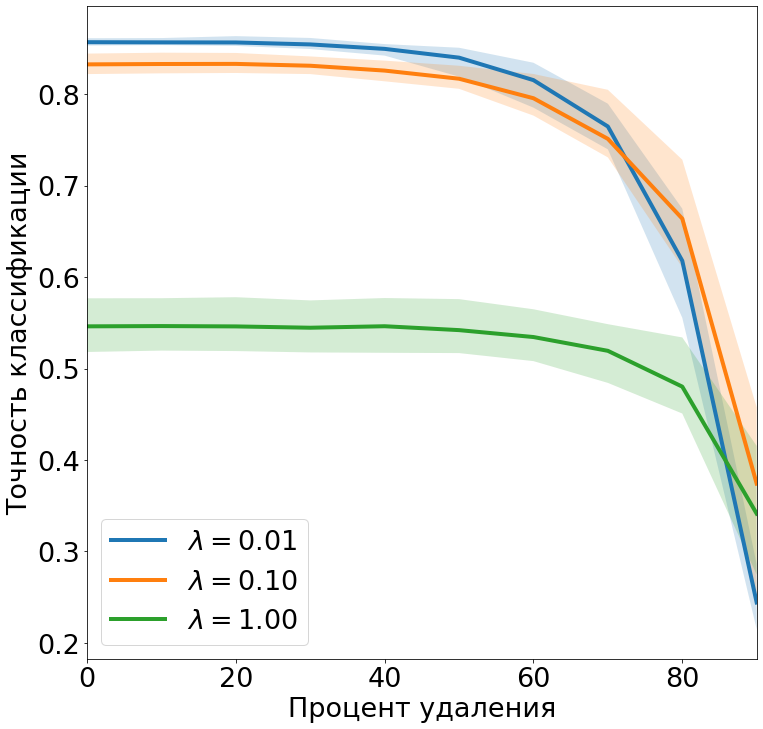

In [8]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Var')
#plt.show()
